In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from datetime import datetime
import numpy as np
# from sklearn.datasets import load_breast_cancer
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='AppleGothic'
#https://teddylee777.github.io/visualization/matplotlib-%EC%8B%9C%EA%B0%81%ED%99%94-%ED%95%9C%EA%B8%80%ED%8F%B0%ED%8A%B8%EC%A0%81%EC%9A%A9
%matplotlib inline 
#쥬피터노트북에서 이미지 표시가능하게 하는 쥬피터노트북 매직함수
temp=pd.read_csv("전국일평균체감온도.csv")
temp[temp["일시"]=='2012-01-01']


temp["일시"] = temp["일시"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))
temp["년"] = temp["일시"].apply(lambda x : x.year)
temp["월"] = temp["일시"].apply(lambda x : x.month)
temp["일"] = temp["일시"].apply(lambda x : x.day)
temp["일자"]=temp["일시"].dt.date


부산,서울,울산,인천,전남,전북,제주,충남,충북,세종

In [2]:
aa=temp[(temp['지역']=='부산')|(temp['지역']=='서울')|(temp['지역']=='울산')|(temp['지역']=='인천')|(temp['지역']=='전남')|(temp['지역']=='전북')|(temp['지역']=='제주')|(temp['지역']=='충남')|(temp['지역']=='충북')|(temp['지역']=='세종')]
aa

,일시,지역,체감온도(°C),년,월,일,일자
2562,2012-01-01,부산,-8.400000,2012,1,1,2012-01-01
2563,2012-01-02,부산,-11.500000,2012,1,2,2012-01-02
2564,2012-01-03,부산,-8.500000,2012,1,3,2012-01-03
2565,2012-01-04,부산,-9.700000,2012,1,4,2012-01-04
2566,2012-01-05,부산,-13.200000,2012,1,5,2012-01-05
...,...,...,...,...,...,...,...
18627,2014-12-27,세종,-9.733333,2014,12,27,2014-12-27
18628,2014-12-28,세종,-8.266667,2014,12,28,2014-12-28
18629,2014-12-29,세종,-1.933333,2014,12,29,2014-12-29
18630,2014-12-30,세종,-3.266667,2014,12,30,2014-12-30


In [3]:
aa.isnull().sum()

일시            0
지역            0
체감온도(°C)    680
년             0
월             0
일             0
일자            0
dtype: int64

## 앞뒤의 데이터가 있다면, 앞뒤의 평균으로 결측값 채우기

In [4]:
def 일차결측치제거(data):
    
    측정목록 = ["체감온도(°C)"]
    결과리스트 = []

    # 데이터프레임 copy하기
    df = data.copy()
    
    for 항목 in 측정목록:
        for idx,row in df[df[항목].isnull()].iterrows():
            
            if df.loc[idx+1,항목] != np.nan:
                
                if df.loc[idx-1,항목] != np.nan:
                    
                    df.loc[idx,항목] = ( df.loc[idx+1,항목]+df.loc[idx-1,항목] ) / 2
                    
    결과리스트.append(df)
    
    return pd.concat(결과리스트,axis=0,ignore_index = True)

In [5]:
bb=일차결측치제거(aa)

In [6]:
print("결측치 처리 이전",aa.isnull().sum().sum())
print("결측치 처리 이후",bb.isnull().sum().sum())

결측치 처리 이전 680
결측치 처리 이후 613


## 데이터가 연속적으로 없다면 해당 일, 예를 들어 1월 1일의 데이터가 2012년 ,2013년, 2014년 중 한 개라도 존재 한다면 평균을 내어 사용


In [7]:
부산=bb[(bb["지역"]=='부산')]
서울=bb[(bb["지역"]=='서울')]
울산=bb[(bb["지역"]=='울산')]
인천=bb[(bb["지역"]=='인천')]
전남=bb[(bb["지역"]=='전남')]
전북=bb[(bb["지역"]=='전북')]
제주=bb[(bb["지역"]=='제주')]
충남=bb[(bb["지역"]=='충남')]
충북=bb[(bb["지역"]=='충북')]
세종=bb[(bb["지역"]=='세종')]

In [8]:
def 이차결측치제거(지역):
    
    
    region_list=[지역]

    month_list=[1,2,3,4,5,6,7,8,9,10,11,12]

    temp_2012=[]
    temp_2013=[]
    temp_2014=[]

    for region in region_list:
    
        for month in month_list:
        
            w=bb[(bb["지역"]==region)&(bb["년"]==2012)&(bb["월"]==month)]
            w_t=w["체감온도(°C)"]
            w_t.reset_index(drop=True,inplace=True)
            ww=bb[(bb["지역"]==region)&(bb["년"]==2013)&(bb["월"]==month)]
            ww_t=ww["체감온도(°C)"]
            ww_t.reset_index(drop=True,inplace=True)
            www=bb[(bb["지역"]==region)&(bb["년"]==2014)&(bb["월"]==month)]
            www_t=www["체감온도(°C)"]
            www_t.reset_index(drop=True,inplace=True)

            qq=pd.concat([w_t,ww_t,www_t],axis=1)
            qq.columns=["2012","2013","2014"]
        
        
            i=0
            while i < len(qq):
                if (qq.loc[i].isnull().sum()==1)|(qq.loc[i].isnull().sum()==2):
                    c=qq.loc[[i]].mean(axis='columns')
                    qq.loc[[i]]=qq.loc[[i]].fillna(float(c))
                i+=1
        
        
            temp_2012.append(qq['2012'])
            temp_2013.append(qq['2013'])
            temp_2014.append(qq['2014'])
        
    a1=pd.concat([temp_2012[0],temp_2012[1],temp_2012[2],temp_2012[3],temp_2012[4],temp_2012[5],temp_2012[6],temp_2012[7],temp_2012[8],temp_2012[9],temp_2012[10],temp_2012[11]])
    temp_2013[1].drop(28,inplace=True) ## 2월달 28일까지만 있어서
    a2=pd.concat([temp_2013[0],temp_2013[1],temp_2013[2],temp_2013[3],temp_2013[4],temp_2013[5],temp_2013[6],temp_2013[7],temp_2013[8],temp_2013[9],temp_2013[10],temp_2013[11]])
    temp_2014[1].drop(28,inplace=True) ## 2월달 28일까지만 있어서
    a3=pd.concat([temp_2014[0],temp_2014[1],temp_2014[2],temp_2014[3],temp_2014[4],temp_2014[5],temp_2014[6],temp_2014[7],temp_2014[8],temp_2014[9],temp_2014[10],temp_2014[11]])

    df1=pd.DataFrame(data=a1)
    df1.columns=["1"]
    df2=pd.DataFrame(data=a2)
    df2.columns=["1"]
    df3=pd.DataFrame(data=a3)
    df3.columns=["1"]
    df=pd.concat([df1,df2,df3])
    dff=df.reset_index(drop=True)
    dff
       
    
    return dff




In [9]:
#지역 ="부산","서울","울산","인천","전남","전북","제주","충남","충북","세종" // "" 해야 함.

이차결측치제거("부산")
부산.drop("체감온도(°C)",axis=1,inplace=True)
부산.insert(1,"체감온도(°C)",이차결측치제거("부산"))
부산=부산.reset_index(drop=True)

이차결측치제거("서울")
서울.drop("체감온도(°C)",axis=1,inplace=True)
서울.insert(1,"체감온도(°C)",이차결측치제거("서울"))
서울=서울.reset_index(drop=True)

이차결측치제거("울산")
울산.drop("체감온도(°C)",axis=1,inplace=True)
울산.insert(1,"체감온도(°C)",이차결측치제거("울산"))
울산=울산.reset_index(drop=True)

이차결측치제거("인천")
인천.drop("체감온도(°C)",axis=1,inplace=True)
인천.insert(1,"체감온도(°C)",이차결측치제거("인천"))
인천=인천.reset_index(drop=True)

이차결측치제거("전남")
전남.drop("체감온도(°C)",axis=1,inplace=True)
전남.insert(1,"체감온도(°C)",이차결측치제거("전남"))
전남=전남.reset_index(drop=True)

이차결측치제거("전북")
전북.drop("체감온도(°C)",axis=1,inplace=True)
전북.insert(1,"체감온도(°C)",이차결측치제거("전북"))
전북=전북.reset_index(drop=True)

이차결측치제거("제주")
제주.drop("체감온도(°C)",axis=1,inplace=True)
제주.insert(1,"체감온도(°C)",이차결측치제거("제주"))
제주=제주.reset_index(drop=True)

이차결측치제거("충남")
충남.drop("체감온도(°C)",axis=1,inplace=True)
충남.insert(1,"체감온도(°C)",이차결측치제거("충남"))
충남=충남.reset_index(drop=True)

이차결측치제거("충북")
충북.drop("체감온도(°C)",axis=1,inplace=True)
충북.insert(1,"체감온도(°C)",이차결측치제거("충북"))
충북=충북.reset_index(drop=True)

이차결측치제거("세종")
세종.drop("체감온도(°C)",axis=1,inplace=True)
세종.insert(1,"체감온도(°C)",이차결측치제거("세종"))
세종=세종.reset_index(drop=True)

/Users/hyungjun/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 여전히 결측치가 발생하는 이유는 예를 들어 1월 13일의 데이터가 앞뒤로도 없어 평균을 못내고,  2012년, 2013년, 2014년 데이터가 모두 없는 경우

부산 120개,서울 21개 ,울산 48개 ,인천 6개 ,전남 6개 ,전북 0개 ,제주 87개 ,충남 0개 ,충북 0개 ,세종 3개

In [10]:
import matplotlib.pyplot as plt
from scipy import interpolate
부산_2012=부산[(부산["년"]==2012)]
부산_2013=부산[(부산["년"]==2013)]
부산_2014=부산[(부산["년"]==2014)]

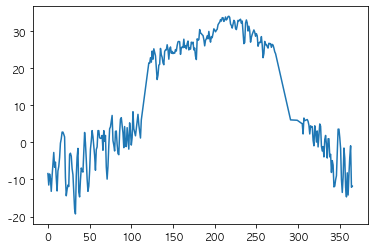

In [11]:
x = 부산_2012[부산_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 부산_2012[부산_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

plt.plot(x, y)
plt.show()

In [12]:
f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

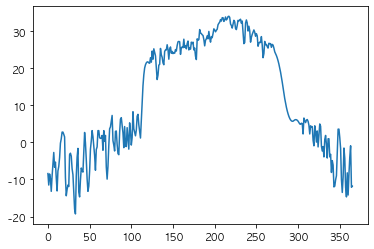

In [13]:
plt.plot(xnew, ynew, '-')
plt.show()

In [14]:
부산_2012["체감온도(°C)"] = ynew



/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/632922258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  부산_2012["체감온도(°C)"] = ynew


## interpolate를 통한 값 추정

In [15]:
부산_2012=부산[(부산["년"]==2012)]
부산_2013=부산[(부산["년"]==2013)]
부산_2014=부산[(부산["년"]==2014)]

x = 부산_2012[부산_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 부산_2012[부산_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

부산_2012["체감온도(°C)"] = ynew

x = 부산_2013[부산_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 부산_2013[부산_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

부산_2013["체감온도(°C)"] = ynew

x = 부산_2014[부산_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 부산_2014[부산_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

부산_2014["체감온도(°C)"] = ynew

부산=pd.concat([부산_2012,부산_2013,부산_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/1470632494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  부산_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/1470632494.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  부산_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/1470632494.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [16]:
서울_2012=서울[(서울["년"]==2012)]
서울_2013=서울[(서울["년"]==2013)]
서울_2014=서울[(서울["년"]==2014)]

x = 서울_2012[서울_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 서울_2012[서울_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

서울_2012["체감온도(°C)"] = ynew

x = 서울_2013[서울_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 서울_2013[서울_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

서울_2013["체감온도(°C)"] = ynew

x = 서울_2014[서울_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 서울_2014[서울_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

서울_2014["체감온도(°C)"] = ynew

서울=pd.concat([서울_2012,서울_2013,서울_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/3384134741.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  서울_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/3384134741.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  서울_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/3384134741.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [17]:
울산_2012=울산[(울산["년"]==2012)]
울산_2013=울산[(울산["년"]==2013)]
울산_2014=울산[(울산["년"]==2014)]

x = 울산_2012[울산_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 울산_2012[울산_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

울산_2012["체감온도(°C)"] = ynew

x = 울산_2013[울산_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 울산_2013[울산_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

울산_2013["체감온도(°C)"] = ynew

x = 울산_2014[울산_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 울산_2014[울산_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

울산_2014["체감온도(°C)"] = ynew

울산=pd.concat([울산_2012,울산_2013,울산_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/814039075.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  울산_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/814039075.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  울산_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/814039075.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [18]:
인천_2012=인천[(인천["년"]==2012)]
인천_2013=인천[(인천["년"]==2013)]
인천_2014=인천[(인천["년"]==2014)]

x = 인천_2012[인천_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 인천_2012[인천_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

인천_2012["체감온도(°C)"] = ynew

x = 인천_2013[인천_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 인천_2013[인천_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

인천_2013["체감온도(°C)"] = ynew

x = 인천_2014[인천_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 인천_2014[인천_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

인천_2014["체감온도(°C)"] = ynew

인천=pd.concat([인천_2012,인천_2013,인천_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/788759565.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  인천_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/788759565.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  인천_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/788759565.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [19]:
전남_2012=전남[(전남["년"]==2012)]
전남_2013=전남[(전남["년"]==2013)]
전남_2014=전남[(전남["년"]==2014)]

x = 전남_2012[전남_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 전남_2012[전남_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

전남_2012["체감온도(°C)"] = ynew

x = 전남_2013[전남_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 전남_2013[전남_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

전남_2013["체감온도(°C)"] = ynew

x = 전남_2014[전남_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 전남_2014[전남_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

전남_2014["체감온도(°C)"] = ynew

전남=pd.concat([전남_2012,전남_2013,전남_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/3664095489.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  전남_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/3664095489.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  전남_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/3664095489.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [78]:
제주_2012=제주[(제주["년"]==2012)]
제주_2013=제주[(제주["년"]==2013)]
제주_2014=제주[(제주["년"]==2014)]

x = 제주_2012[제주_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 제주_2012[제주_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]


f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

제주_2012["체감온도(°C)"] = ynew

x = 제주_2013[제주_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 제주_2013[제주_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

제주_2013["체감온도(°C)"] = ynew

x = 제주_2014[제주_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 제주_2014[제주_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

제주_2014["체감온도(°C)"] = ynew

제주=pd.concat([제주_2012,제주_2013,제주_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/1219938908.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  제주_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/1219938908.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  제주_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/1219938908.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [79]:
세종_2012=세종[(세종["년"]==2012)]
세종_2013=세종[(세종["년"]==2013)]
세종_2014=세종[(세종["년"]==2014)]

x = 세종_2012[세종_2012["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 세종_2012[세종_2012["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(0,366)]
ynew = f(xnew)

세종_2012["체감온도(°C)"] = ynew

x = 세종_2013[세종_2013["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 세종_2013[세종_2013["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(366,731)]
ynew = f(xnew)

세종_2013["체감온도(°C)"] = ynew

x = 세종_2014[세종_2014["체감온도(°C)"].notnull()]["체감온도(°C)"].index
y = 세종_2014[세종_2014["체감온도(°C)"].notnull()]["체감온도(°C)"]

f = interpolate.interp1d(x, y,kind="quadratic")
xnew = [i for i in range(731,1096)]
ynew = f(xnew)

세종_2014["체감온도(°C)"] = ynew

세종=pd.concat([세종_2012,세종_2013,세종_2014])

/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/781977403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  세종_2012["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/781977403.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  세종_2013["체감온도(°C)"] = ynew
/var/folders/1n/q8jkp3w162g0c33kd5n7j75c0000gn/T/ipykernel_3028/781977403.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

### 결측 처리 완료

In [82]:
일부2=pd.concat([부산,서울,울산,인천,전남,전북,제주,충남,충북,세종])
일부2.reset_index(drop=True, inplace=True)
일부2.drop(["년","월","일","일자"],axis=1,inplace=True)
일부2=일부2[["일시","지역","체감온도(°C)"]]
일부2

,일시,지역,체감온도(°C)
0,2012-01-01,부산,-8.400000
1,2012-01-02,부산,-11.500000
2,2012-01-03,부산,-8.500000
3,2012-01-04,부산,-9.700000
4,2012-01-05,부산,-13.200000
...,...,...,...
10955,2014-12-27,세종,-9.733333
10956,2014-12-28,세종,-8.266667
10957,2014-12-29,세종,-1.933333
10958,2014-12-30,세종,-3.266667


In [63]:
일부1=pd.read_csv("강원~대전 결측치 처리.csv") ### 용훈님이 처리
일부1.drop("Unnamed: 0",axis=1,inplace=True)
일부1["일시"] = 일부1["일시"].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))
일부1_1=일부1[(일부1["지역"]=="강원")|(일부1["지역"]=="경기")|(일부1["지역"]=="경남")|(일부1["지역"]=="경북")|(일부1["지역"]=="광주")|(일부1["지역"]=="대구")|(일부1["지역"]=="대전")]

일부1_1

,일시,지역,체감온도(°C)
0,2012-01-01,강원,-10.592308
1,2012-01-02,강원,-13.607692
2,2012-01-03,강원,-13.461538
3,2012-01-04,강원,-15.646154
4,2012-01-05,강원,-17.330769
...,...,...,...
7667,2014-12-27,대전,-8.000000
7668,2014-12-28,대전,-8.700000
7669,2014-12-29,대전,-1.200000
7670,2014-12-30,대전,-2.600000


In [84]:
통합=pd.concat([일부1_1,일부2])
통합.reset_index(drop=True,inplace=True)
통합

,일시,지역,체감온도(°C)
0,2012-01-01,강원,-10.592308
1,2012-01-02,강원,-13.607692
2,2012-01-03,강원,-13.461538
3,2012-01-04,강원,-15.646154
4,2012-01-05,강원,-17.330769
...,...,...,...
18627,2014-12-27,세종,-9.733333
18628,2014-12-28,세종,-8.266667
18629,2014-12-29,세종,-1.933333
18630,2014-12-30,세종,-3.266667


In [85]:
통합.to_csv("체감온도 결측치 제거.csv", index=False)